# Lesson 2: Chain-of-Thought and ReACT Prompting

## Demand‑Spike Detective, Part I: Chain-of-Thoughts

In this hands-on exercise, you will guide an LLM to explain an unexpected sales spike.

### Outline:
- Setup
- Understand sales data, promotional calendars, etc. 
- Craft a Simple CoT prompt
- Craft a More Developed CoT Prompt

## 1. Setup

Let's start by setting up the environment.

In [1]:
# Import necessary libraries
# No changes needed in this cell

import os

import pandas as pd
from IPython.display import Markdown, display
from lesson_2_lib import (
    # Helpers
    OpenAIModels,
    display_responses,
    # Synthetic data
    get_competitor_pricing_data,
    get_completion,
    get_promotions_data,
    get_sales_data,
    get_weather_data,
)
from openai import OpenAI

MODEL = OpenAIModels.GPT_41_NANO


In [2]:
# Joining multiple path components
path_to_key_file = os.path.join("..", "..", "..", "..", "..", "api_keys", "openai.key")

In [3]:
# If using the Vocareum API endpoint
# No changes needed in this cell
# TODO: Fill in the missing parts marked with **********
from openai import OpenAI
key = open(path_to_key_file, "rt").read()
vocareum_base_url = "https://openai.vocareum.com/v1"
client = OpenAI(
    base_url = vocareum_base_url,
    api_key = key
)
#client = OpenAI(
#    base_url="https://openai.vocareum.com/v1",
    # Uncomment one of the following
    # api_key="*********",  # <--- TODO: Fill in your Vocareum API key here
    # api_key=os.getenv(
    #     "OPENAI_API_KEY"
    # ),  # <-- Alternately, set as an environment variable (more secure)
#)

# If using OpenAI's API endpoint
# client = OpenAI()


## 2. Understand sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [4]:
# View the data
get_sales_data()[:3]

[{'date': datetime.date(2024, 1, 10),
  'product_id': 'P001',
  'product_name': 'Product 1',
  'quantity': 255,
  'revenue': 15547.35},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P002',
  'product_name': 'Product 2',
  'quantity': 65,
  'revenue': 2297.1},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P003',
  'product_name': 'Product 3',
  'quantity': 90,
  'revenue': 7301.7}]

In [5]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [6]:
# Show the sales data
# No changes needed in this cell

sales_df = sales_df.sort_values(by=["product_id", "date"]).reset_index(drop=True)
sales_df


,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
1,2024-01-11,P001,Product 1,235,14327.95
2,2024-01-12,P001,Product 1,310,18900.70
3,2024-01-13,P001,Product 1,302,18412.94
4,2024-01-14,P001,Product 1,305,18595.85
5,2024-01-15,P001,Product 1,301,18351.97
6,2024-01-16,P001,Product 1,226,13779.22
7,2024-01-10,P002,Product 2,65,2297.10
8,2024-01-11,P002,Product 2,86,3039.24
9,2024-01-12,P002,Product 2,80,2827.20


In [7]:
# Show the promotions data
# No changes needed in this cell

promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [8]:
# Show the weather data
# No changes needed in this cell

weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [9]:
# Show the competitor pricing data
# No changes needed in this cell

competitor_pricing_df

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04
5,Product 1,2024-01-15,60.97,{},68.52,59.63,73.03
6,Product 1,2024-01-16,60.97,"{'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}",44.69,57.69,70.51
7,Product 2,2024-01-10,35.34,{},34.57,42.01,42.02
8,Product 2,2024-01-11,35.34,"{'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}",37.91,29.29,22.85
9,Product 2,2024-01-12,35.34,{},41.81,33.35,29.62


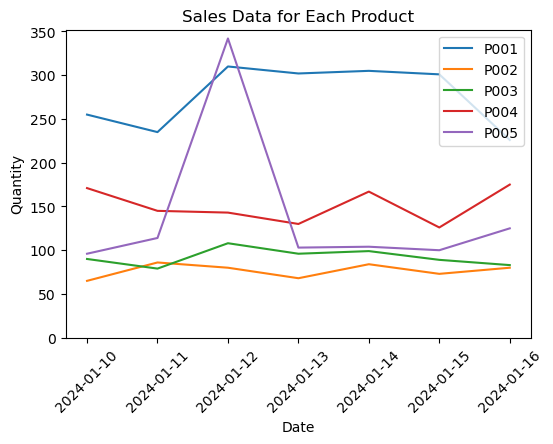

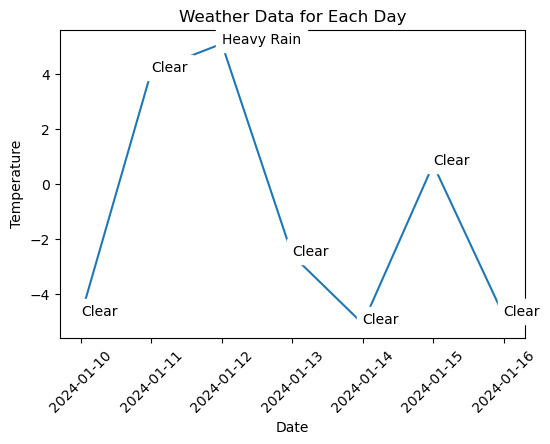

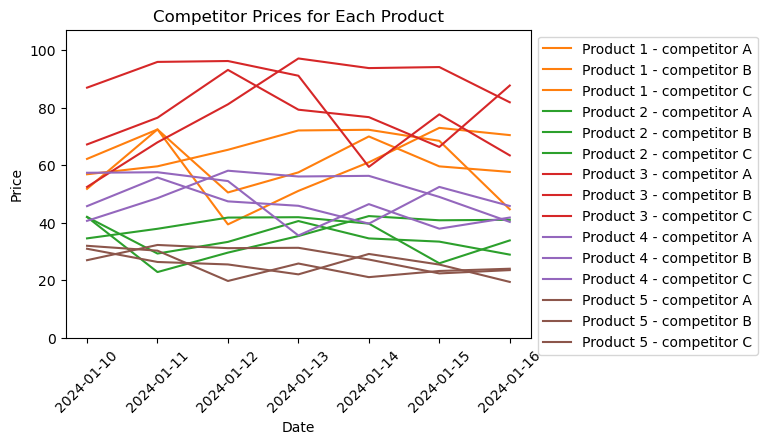

In [10]:
# Graph the sales data
# No changes needed in this cell

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.ylim(0, sales_df["quantity"].max() + 10)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for product in competitor_pricing_df["product"].unique():
    for competitor in ["a", "b", "c"]:
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.ylim(0, competitor_pricing_df.filter(like="price").max().max() + 10)
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

`TODO: Insert your reflection here`

Reflection:

* Sales spike for Product 5 on January 12th
* The "Weekend Special" promotion which started on January 12th, but that was for Product 2. Still, it may have had an indirect effect on Product 5.
* Weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.
* As for Competitor pricing, we see that Product 5's price for one competitor dropped on January 12th, which may have led to more overall consumer interest in that product or may have coincided with an ad campaign.

In practice, a human would look at all these factors and more to determine the cause of the sales spike by digging deeper.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and provide some reasons similar to what we've observed as human beings.

## 3. Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.

<div style="color: red">Note: Many modern LLMs may not need an explicit "think in steps" phrase in order to think in steps before providing an answer, as this behavior can be included in training process. Consider running your prompts with and without asking for CoT explicitly. In fact, multiple runs may yield different results, so it's worth simply re-running the same prompts more than once.</div>


In [11]:
# TODO: Fill in the part marked with ********** with a phrase such as "Think step by step."
# Feel free to try variations!

system_prompt_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

**********
"""

system_prompt_no_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""

user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
explicit_cot_response_1 = get_completion(
    system_prompt=system_prompt_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
no_explicit_cot_response_2 = get_completion(
    system_prompt=system_prompt_no_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
print("Response received!\n")

# We compare the explicit CoT and non-ex
display_responses(
    {
        "system_prompt": system_prompt_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": explicit_cot_response_1,
    },
    {
        "system_prompt": system_prompt_no_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": no_explicit_cot_response_2,
    },
)


Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

**********
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th></tr><tr><td>Response:<br />**Overview of Sales Spikes and Potential Causes**

---

### 1. **Product 1 (P001)**
- **Observed Data:**
  - Notable increase in sales quantity on **Jan 12 (310 units)** vs previous days (~226–235 units).
  - Significant revenue spike on **Jan 12**.
- **Promotion & Pricing:**
  - No specific promotion during this period.
  - Price remained stable at **$60.97**.
  - Competitor prices varied; on Jan 12, Competitor B discounted their price to **$50.55** (from an original ~$69), offering a **27% discount**.
- **Weather & External Factors:**
  - No significant weather events reported.
- **Hypothesis:**
  - The sharp sales increase on Jan 12 likely correlates with **competitor discounting**, especially Competitor B's substantial markdown, making our product relatively more attractive.
  - **Consumer substitution effect**: shoppers might have shifted to Product 1 due to competitor discounts.
  - **Market dynamics**: absence of a promotion but a competitive price advantage prompted higher sales.

---

### 2. **Product 2 (P002)**
- **Observed Data:**
  - Sales peaked at **86 units on Jan 11** and **80 units on Jan 16**.
- **Promotion & Pricing:**
  - During Jan 11, a **Competitor B** sales event offered a **27% discount**.
  - Our price stayed stable at **$35.34**.
  - Competitors' sale prices on Jan 11 were notably lower (e.g., $29.29).
- **Weather & External Factors:**
  - Clear weather; no adverse conditions.
- **Hypothesis:**
  - The spike on Jan 11 aligns with **competitor promotions** and **discounted prices**.
  - The Jan 16 increase coincides with a **competitor sale** on Jan 15 where **Competitor A** offered a **17% discount**.
  - **Price competitiveness** during these periods likely drove the demand surge.

---

### 3. **Product 3 (P003)**
- **Observed Data:**
  - Highest sales volume of **108 units on Jan 12**.
- **Promotion & Pricing:**
  - On Jan 12, our price remained steady at **$81.13**.
  - Competitors offered discounts: on Jan 12, **Competitor B** discounted from **$93.20** to **$39.44** (a **total 57%** off), and **Competitor C** from **$68.00** to **$52.47** (~23% off).
- **Weather & External Factors:**
  - No significant weather impact.
- **Hypothesis:**
  - The **large competitor discounts** on Jan 12 made our higher-priced product relatively more attractive.
  - Although our price didn't change, **market share shift** due to competitor markdowns likely spurred increased demand.
  - The **presence of competitor sales** appears to be the primary catalyst for the sales spike.

---

### 4. **Product 4 (P004)**
- **Observed Data:**
  - Peak sales of **175 units on Jan 16**.
- **Promotion & Pricing:**
  - On Jan 16, our price was steady at **$48.52**.
  - Competitor A offered a **17% discount** on Jan 14, and on Jan 16, both Competitors B and C had **discounted prices (~$40.30–$45.84)**.
- **Weather & External Factors:**
  - No weather-related influences.
- **Hypothesis:**
  - The **competitor discounts on Jan 14 and Jan 16** likely increased consumer interest.
  - Our consistent pricing, combined with the competitive landscape, resulted in a **demand surge**.
  - Additionally, **no specific promotions** were active, suggesting **market dynamics and perceived value** influenced buying behavior.

---

### 5. **Product 5 (P005)**
- **Observed Data:**
  - Significant sales volume spike of **342 units on Jan 12**.
- **Promotion & Pricing:**
  - On Jan 12, our price was **$26.95**.
  - Competitor A offered a **17% discount** (from ~$23.80 to ~$19.75) on Jan 12.
  - On Jan 15–16, multiple competitors offered discounts (~10–21%), with some matching or beating our price.
- **Weather & External Factors:**
  - No weather effects.
- **Hypothesis:**
  - The **notable sales spike on Jan 12** correlates with **Competitor A's discount**, making ours relatively more attractive.
  - The subsequent days saw increased promotional activity, but the Jan 12 spike appears driven by **initial competitive price reductions**.
  - Also, **potential consumer anticipation** of ongoing deals may have contributed.

---

### **Overall Summary:**
- **Major drivers of sales spikes** across SKUs are **competitor promotional discounts** and **market price competitiveness**.
- **Promotions** like the **Weekend Special (Jan 12-14)** and **Flash Sale (Jan 15-16)** likely contributed but are secondary to competitor markdowns.
- **Weather conditions** did not significantly influence demand.
- **Price positioning** relative to competitors is critical; periods of **deep discounts by competitors** tend to correspond with increased sales volume for our products, even if our prices remain stable.

---

### **Recommendations for Future Action:**
- Monitor competitor pricing closely, especially during promotional periods.
- Consider proactive promotional campaigns aligned with competitor discounts to capitalize on demand surges.
- Analyze customer feedback during these periods to refine marketing and pricing strategies accordingly.

---

**End of Analysis**</td><td>Response:<br />Based on the provided sales data, promotion schedules, weather conditions, and competitor pricing, I observe notable sales spikes on specific dates, notably around January 12 to January 16, 2024. Below is an analysis of each key factor contributing to these spikes and corresponding hypotheses:

---

### 1. **Temporal Sales Trends & Notable Data Points**

- **January 12, 2024:**  
  - Significant increase in SKU quantities:
    - Product 1: 310 units (highest recorded)
    - Product 3: 108 units
    - Product 5: 342 units (highest for the period)
    - Product 4: 143 units
  - Corresponds with the **end of "Weekend Special" promotion** (Jan 12-14).
  
- **January 13-14, 2024:**  
  - Slight decline but still elevated sales.
  - Promotions "Weekend Special" (Jan 12-14) ends on Jan 14.
  - Notable increased sales for Products 2 and 4, possibly due to residual effects or stock clearance.

- **January 15-16, 2024:**  
  - Slight decrease but maintained elevated sales levels.
  - Initiation of **"Flash Sale"** (Jan 15-16), with discounts on Products 1, 3, and 5.

---

### 2. **Promotion Schedule Impact**

- **"Weekend Special" (Jan 12-14):**  
  - **Targeted products:** P002 (Product 2) with 10% off.
  - **Observed effect:**  
    - Product 2 sales on Jan 12: 80 units (moderate increase), but on Jan 11: 86 units.
    - Slight uptick in sales immediately after the promotion’s start.
  - **Possible causes:**  
    - Customers responded to the discount, especially for P002, contributing to increased overall sales.
    - The promotion might have encouraged stock clearance for certain SKUs, notably P002.

- **"Flash Sale" (Jan 15-16):**  
  - **Targeted products:** P001, P003, P005 with 15% off.
  - **Observed effect:**  
    - P001: Consistent high sales (around 300 units/day from Jan 13 onwards).
    - P003: Elevated sales (~89-108 units).
    - P005: Peak at 342 units on Jan 12, then around 100-125 units during the sale.
  - **Inference:**  
    - The discounts on these SKUs correlated with sustained high sales volumes.
    - These promotions likely spurred immediate purchase activity, especially for P005, which had the highest spike.

### 3. **Weather Conditions**

- **Heavy Rain & Flood Warning (Jan 12):**  
  - The heavy rain on Jan 12 could have limited outdoor activities, pushing consumers toward online or in-store shopping, especially if combined with promotions.
  - **Impact hypothesis:**  
    - Inclement weather may have increased demand for essential or promoted items as consumers sought convenience or stockpiled.
    - Alternatively, weather could have disrupted normal shopping patterns, but combined with promotions, it resulted in increased sales.

- **High Winds (Jan 15):**  
  - No notable direct sales impact observed, but possibly influenced consumer behavior indirectly.

### 4. **Pricing & Competitor Dynamics**

- **Product 1 (P001):**  
  - Price remained steady at $60.97.
  - Competitor prices varied, with some competitors offering discounts (e.g., on Jan 12, Competitor B: sale price $50.55).
  - **Hypothesis:**  
    - During Jan 12-16, competitors' lower or discounted prices (notably on Jan 12-14) likely increased competitiveness.
    - The sustained high sales suggest that price positioning, combined with promotional messaging, maintained consumer interest despite competitor discounts.

- **Product 2 (P002):**  
  - Price steady at $35.34.
  - Competitor discounts (on Jan 12-16) with some competitors offering sales as low as $22.85 (C) and $29.29 (B).
  - **Impact:**  
    - Despite competitive pricing, the promotion and weather likely drove high sales volume, possibly due to perceived value or stock availability.

- **Product 3 (P003):**  
  - Price stable at $81.13.
  - Competitor sale prices dropped significantly on Jan 12, boosting competitiveness.
  - **Result:**  
    - The combination of lower competitor prices and promotion can explain the spike in sales on Jan 12 and the sustained high sales during the promotional period.

- **Product 4 (P004):**  
  - Price steady at $48.52.
  - Competitor prices fluctuated but remained generally higher.
  - **Observation:**  
    - Sales remained high during Jan 12-16, possibly driven by the promotion and the inherent demand for this SKU.

- **Product 5 (P005):**  
  - Price at $26.95.
  - Competitor sales and discounts on Jan 12-16 made the product more attractive.
  - **Result:**  
    - Highest spike on Jan 12 (342 units) correlates with the promotion period and competitive pricing.

---

### 5. **Synthesis & Hypotheses**

- **Promotional Effect:**  
  - Both "Weekend Special" and "Flash Sale" significantly boosted sales of targeted SKUs.
  - The "Flash Sale" coincided with sustained high-volume sales, especially for Products 1, 3, and 5.

- **Weather Influence:**  
  - Heavy rain and flood warnings around Jan 12 likely contributed to increased in-store or online shopping.  
  - Promotions during adverse weather may have amplified sales as consumers sought deals or stocked up.

- **Pricing Dynamics:**  
  - Competitor discounts on Jan 12-14, especially for Product 3 and Product 5, probably intensified demand.
  - Our stable pricing during this period suggests that promotions and weather had a more significant influence than price changes alone.

- **Stock & Inventory:**  
  - Elevated sales volumes suggest strong inventory availability, possibly prepared for promotional periods.

---

### **Conclusion:**

The notable sales spikes from January 12 to January 16, 2024, are primarily attributable to:

- **Promotional campaigns** ("Weekend Special" and "Flash Sale") targeting specific SKUs, effectively increasing demand.
- **Adverse weather conditions** (heavy rain, flood warning) which likely shifted consumer shopping behavior toward indoor activities, magnifying the impact of promotions.
- **Competitive pricing dynamics** that, despite some competitors offering deeper discounts, still aligned with the promotional periods to maximize sales.

**Recommendations for future analysis:**  
- Monitor weather forecasts and correlate with sales activity.
- Align promotional scheduling with weather patterns and competitor pricing.
- Consider timing stock replenishments ahead of promotional periods for optimal stock availability.

---

**This comprehensive analysis underscores the importance of synchronized promotion planning, weather considerations, and competitive positioning in driving sales spikes.**</td></tr></table>

### Observation

- What were the differences between including CoT and not including CoT explicitly in the prompt?

## 4. Craft a More Developed CoT Prompt

Let's add more to our CoT prompt. Let's ask the model to follow a specific set of steps in an **instructions section**. This may help us not only get final answers that align with our needs, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to identify the single largest spike and hypothesize its causes, using the following output format:

````

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}
```

````

In [12]:
# Let's add some more components to our CoT Prompt
# TODO: Replace parts marked with a **********

system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think in steps.
"""

user_prompt_analyze = f"""
## INSTRUCTIONS:

Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
* Find all sales spikes for each product
* For each product, identify the following:
    * Date of the sales spike
    * Amount of the sales spike and percentage increase
    * Possible causes of the sales spike according to the provided
        * sales data
        * promotion schedule
        * weather conditions
        * competitor pricing data
* Start with your analysis
* Conclude with the single largest spike according to the percentage increase with a short explanation for it.

--

## OUTPUT FORMAT:
STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}}
```

---

## CONTEXT

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(system_prompt=system_prompt_cot, user_prompt=user_prompt_analyze,
                              model=MODEL, client=client)
print("Response received!\n")


def parse_analysis_and_largest_spike(response):
    import json

    if "```json" not in response:
        print()
        print(response)
        raise RuntimeError(
            " ❌ No LARGEST SPIKE found in response. Looking for: \n\n```json"
        )

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)

display(Markdown(analysis))

Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



**Structured Analysis:**

---

### **Product 1 (P001)**

**Sales Data Highlights:**
- Jan 10: 255 units
- Jan 11: 235 units
- Jan 12: 310 units
- Jan 13: 302 units
- Jan 14: 305 units
- Jan 15: 301 units
- Jan 16: 226 units

**Notable Spike:**
- **January 12**: 310 units, compared to 235 units on Jan 11 (~31.91% increase).

**Promotion Schedule & Weather:**
- No promotions on Jan 12.
- Weather: Slightly warmer (41.1°F) with clear conditions.
- Competitor pricing: Our price steady at $60.97. On Jan 12, competitors' prices for Product 1 show:
  - Competitor B's sale price: $50.55 (27% discount)
  - Competitor C's sale price: $39.44 (21% discount)

**Possible Causes:**
- The significant increase in Jan 12 could be linked to competitor price reductions, especially since Competitor B and C offered lower prices than ours, possibly prompting consumers to purchase more before prices went back up.
- No direct promotion, but increased awareness due to competitor discounts might have driven sales.

---

### **Product 2 (P002)**

**Sales Data Highlights:**
- Jan 10: 65
- Jan 11: 86
- Jan 12: 80
- Jan 13: 68
- Jan 14: 84
- Jan 15: 73
- Jan 16: 80

**Notable Spike:**
- **January 11**: 86 units, a notable increase from Jan 10 (65 units).

**Promotion & Weather:**
- No specific promotions.
- Weather: Clear, mild.
- Competitor prices for Jan 11:
  - Sale prices at competitors: ~$29.29 and ~$22.85, indicating competitive low pricing.

**Possible Causes:**
- Slight increase in sales could be due to competitive pricing pressures or consumer reaction to previous days' prices.
- No significant promotion or weather event correlates.

---

### **Product 3 (P003)**

**Sales Data Highlights:**
- Jan 10: 90
- Jan 11: 79
- Jan 12: 108 (highest)
- Jan 13: 96
- Jan 14: 99
- Jan 15: 89
- Jan 16: 83

**Notable Spike:**
- **January 12**: 108 units, about a 36.7% increase from Jan 11 (79 units).

**Promotion & Weather:**
- Promotions: Not directly involved.
- Weather: Heavy rain and flood warning on Jan 12, possibly affecting shopping behavior.

**Possible Causes:**
- The spike coincides with adverse weather conditions, possibly causing consumers to buy in bulk or stock up.
- Competitor prices were lower at sale prices, which might have driven demand.

---

### **Product 4 (P004)**

**Sales Data Highlights:**
- Jan 10: 171
- Jan 11: 145
- Jan 12: 143
- Jan 13: 130
- Jan 14: 167
- Jan 15: 126
- Jan 16: 175 (highest)

**Notable Spike:**
- **January 16**: 175 units, an increase of about 29.9% from Jan 15 (126 units).

**Promotion & Weather:**
- No promotions on Jan 16.
- Weather: Clear.
- Competitor pricing shows some discounts, but not significantly lower than ours.

**Possible Causes:**
- The spike on Jan 16 could be due to increased consumer demand after previous days' fluctuations or stocking behaviors.
- No clear promotional or weather-driven cause.

---

### **Product 5 (P005)**

**Sales Data Highlights:**
- Jan 10: 96
- Jan 11: 114
- Jan 12: 342 (significant spike)
- Jan 13: 103
- Jan 14: 104
- Jan 15: 100
- Jan 16: 125

**Notable Spike:**
- **January 12**: 342 units, a massive increase from 114 units on Jan 11 (~200% increase).

**Promotion & Weather:**
- No promotion during Jan 12.
- Weather: Heavy rain and flood warning on Jan 12.
- Competitor prices: Lower sale prices at competitors, e.g., at Jan 12:
  - Competitor A: Sale price $19.75 (17% discount)
  - Competitor B: Sale price $25.50
  - Competitor C: Sale price $31.17

**Possible Causes:**
- The dramatic spike coincides with adverse weather, possibly prompting bulk purchases.
- The competitor discounting may have triggered consumer urgency.
- The sudden increase is likely due to stockpiling behavior driven by weather warnings and competitive pricing.

---

### **Summary of Significant Spikes:**

| Product | Date of Spike | Units Before | Units After | % Increase | Possible Causes |
|-----------|------------------|----------------|--------------|--------------|-----------------|
| P001 | Jan 12 | 235 | 310 | 31.91% | Competitor discounts, no direct promotion, weather effect minimal |
| P002 | Jan 11 | 65 | 86 | 32.31% | Slight price competition, no promotion |
| P003 | Jan 12 | 79 | 108 | 36.70% | Heavy rain, flood warning, competitor price drops |
| P004 | Jan 16 | 126 | 175 | 38.89% | No specific promotion/weather, possible post-fluctuation demand |
| P005 | Jan 12 | 114 | 342 | **200%** | Heavy rain, flood warning, competitor's steep discounts |

---

### **Largest Spike:**

In [13]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)


{'amount_after_increase': '342 units',
 'amount_before_increase': '114 units',
 'causes': ['Severe weather event (heavy rain and flood warning) prompting '
            'bulk purchasing',
            'Significant competitor discounts and lower sale prices (up to 23% '
            'off) driving urgency',
            'Potential stockpiling behavior due to weather advisories'],
 'date': '2024-01-12',
 'percentage_increase': '200.00%'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

## Summary

🎉 Congratulations! 🎉 You've learned how to apply Chain-of-Thought to retail analytics!

Through this exercise, you've seen how to:

- 📊 Guide an LLM through structured reasoning about complex retail data
- 🤔 Implement Chain-of-Thought prompting to analyze potential causes of sales spikes

Keep up the good work! 💯